## Using real-data  

For a "real" data test case, we'll test the different aligners/search software on the virus sequences from IMG/VR4.  
In IMG/VR4  [DOI: 10.1093/nar/gkac1037](https://doi.org/10.1093/nar/gkac1037), the host assignment [workflow](https://github.com/jgi-microbiome-data-science/crispr-host-prediction) identifies spacer-protospacer pairs via `blastn -w 8 --dust no ...  --max_target_seqs 1000` which is roughly equivalent to using `blastn -task short` parameter, followed by filtering the results and using the `assign_host.py` script which utilizes the spacers' lineage information.  
Note, we do not compare any filtereing done after the pairing was done, or the host assignment itself - for that reason, we also do not benchmark dedicated host assignment tools like spacerphaser, wish or iphop (even though they may be useful or utilize spacer-protospacer pairs).  

In our benchmark, we'll use a more updated and curated version of the spacer set compared to the one used in IMG/VR4 - we'll use the CRISPR sapcer set from iphop [https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions](https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions). Specifically, we'll use the June 2025 upload.



## Fetch IMG/VR4
The full IMG/VR4 data can be downloaded from the [JGI portal](https://genome.jgi.doe.gov/portal/pages/dynamicOrganismDownload.jsf?organism=IMG_VR). This requires logining in and selecting the files we want:  
- IMGVR_all_nucleotides-high_confidence.fna
- IMGVR_all_Sequence_information-high_confidence.tsv

For convenience, we'll download the ffasta file from an unstable FTP hosting of them on nersc:
- [IMGVR4_SEQUENCES.fna.zst](https://portal.nersc.gov/genomad/__data__/IMGVR_DATA/IMGVR4_SEQUENCES.fna.zst)


In [ ]:
%%bash
mkdir imgvr4_data
cd imgvr4_data
mkdir spacers contigs

cd contigs
# download the contigs (this may take a while)
wget https://portal.nersc.gov/genomad/__data__/IMGVR_DATA/IMGVR4_SEQUENCES.fna.zst --quiet -O IMGVR4_SEQUENCES.fna.zst
# decompress the file
zstd -d IMGVR4_SEQUENCES.fna.zst
# get the name, length and GC% of the contigs (this may also take a while)
seqkit fx2tab -nl --gc IMGVR4_SEQUENCES.fna  > IMGVR4_SEQUENCES_name_length.tab

Note, we'll use the IMG_VR_2022-09-20_7.1 version of IMG/VR (v4.1, with bugfix in UViG table and protein fasta), and specifically the high-confidence genomes only ( `IMGVR_all_nucleotides-high_confidence.fna`).  
To get the info table, you'll need to login to the JGI portal and download the `IMGVR_all_Sequence_information-high_confidence.tsv` file. The data is free and unrestricted, but still requires registerition or confirming the data use agreement. 


## fetch the spacer set
We are only interested in one (or two) files from the iphop database:
- `All_CRISPR_spacers_nr_clean.fna`
- `Host_Genomes.tsv`



In [ ]:
%%bash
cd imgvr4_data/spacers
wget https://portal.nersc.gov/cfs/m342/iphop/db/extra/All_CRISPR_spacers_nr_clean.fna
wget https://portal.nersc.gov/cfs/m342/iphop/db/extra/Host_Genomes.tsv
# create a table with the name and length of the spacers
seqkit fx2tab -nl All_CRISPR_spacers_nr_clean.fna  > All_CRISPR_spacers_nr_clean_name_length.tab

Next some data wrangling to get the contig info and the spacer info in the same format.

In [ ]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/')
import polars as pl
pl.Config(tbl_rows=50)

from bench import *
from bench.utils.functions import *

contigs_file = 'contigs/IMGVR4_SEQUENCES.fna'
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'

contig_stats = pl.read_csv('contigs/IMGVR4_SEQUENCES_name_length.tab', separator='\t',has_header=False,new_columns=['seqid','length',"GC"])
contig_info = pl.read_csv('contigs/IMGVR_all_Sequence_information-high_confidence.tsv', separator='\t',infer_schema_length=10000, null_values=['N/A'])
contig_info= contig_info.rename({"Coordinates ('whole' if the UViG is the entire contig)":"coordinates"})
contig_info= contig_info.with_columns(
    pl.when(pl.col('coordinates').eq('whole')).then(None).otherwise(pl.col('coordinates')).alias('coordinates')
)
contig_info = contig_info.with_columns(
    pl.concat_str([pl.col('UVIG'),pl.col('Taxon_oid'),pl.col('Scaffold_oid'),pl.col('coordinates')],ignore_nulls=True,separator='|').alias('seqid')
)
print(f"contig_stats.schema: {contig_stats.schema}")
print(f"contig_stats.shape: {contig_stats.shape}")

print(f"contig_info.schema: {contig_info.schema}")
print(f"contig_info.shape: {contig_info.shape}")
contig_stats = contig_stats.join(contig_info, on='seqid', how='inner')

contig_stats = contig_stats.filter(pl.col("length") == pl.col("Length"))
contig_stats = contig_stats.filter(pl.col("Topology") != "GVMAG")

contig_stats = contig_stats.select(["seqid","Taxonomic classification","length","GC","Topology","MIUViG quality","UVIG"])
contig_stats = contig_stats.rename(str.lower)
contig_stats = contig_stats.rename(lambda x: x.lower().replace(" ","_"))

contig_stats = contig_stats.filter(~pl.col("taxonomic_classification").str.contains(";;;;;"))
contig_stats = contig_stats.with_columns(
    pl.when(pl.col("miuvig_quality").str.contains("High-quality|Reference")).then(True).otherwise(False).alias("hq")
)
contig_stats = contig_stats.with_columns([
    pl.col("taxonomic_classification")
    .str.extract(r"r__([^;]*)", 1).alias("realm"),
    pl.col("taxonomic_classification")
    .str.extract(r"k__([^;]*)", 1).alias("kingdom"),
    pl.col("taxonomic_classification")
    .str.extract(r"p__([^;]*)", 1).alias("phylum"),
    pl.col("taxonomic_classification")
    .str.extract(r"c__([^;]*)", 1).alias("class"),
    pl.col("taxonomic_classification")
    .str.extract(r"o__([^;]*)", 1).alias("order"),
    pl.col("taxonomic_classification")
    .str.extract(r"f__([^;]*)", 1).alias("family"),
    pl.col("taxonomic_classification")
    .str.extract(r"g__([^;]*)", 1).alias("genus"),
    pl.col("taxonomic_classification")
    .str.extract(r"s__([^;]*)", 1).alias("species"),
])
contig_stats = contig_stats.drop(["taxonomic_classification","miuvig_quality"])
for i in contig_stats.columns:
    print(f"{i}: {contig_stats[i].value_counts(sort=True)}")
# tmp.head(3)
print(f"new schema: {contig_stats.schema}")
contig_stats.head(3)

Finally, we'll index the contigs file for fast random access later.
This may take a while, but only done once and will save time (later).

In [ ]:
%%bash
pyfastx index contigs/IMGVR4_SEQUENCES.fna
ls -lsh ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna*

158G -rw-rw-r-- 1 uneri grp-org-sc-metagen 158G Sep  4  2022 ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna
2.3G -rw-r--r-- 1 uneri grp-org-sc-metagen 2.3G Oct  7 15:38 ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna.fxi


We'll further curate the spacer set by filtering out very low complexity sequences:  
- no more than 10% of the spacer is Ns
- no homopolymers longer than 8
- All bases are A, T, C, or G must be present.
- Shannon entropy > 0.5
- pydustmasker with a window size of 5 and a score threshold of 18 has no masked bases.


In [35]:
import polars as pl
import pydustmasker as pdm
from bench.utils.functions import  read_fasta_needletail
spacers_file = '../imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna'
spacer_df = pl.DataFrame(read_fasta_needletail(spacers_file), schema={'seqid': pl.Utf8, 'seq': pl.Utf8},)

In [ ]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("N|n")/pl.col("length")).alias("n_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t")/pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c")/pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g")/pl.col("length")).alias("g_frac"),
)
spacer_df = spacer_df.sort("t_frac", descending=True)

Calculating the Shannon entropy of each spacer sequence.  

The Shannon entropy formula is $H = -\sum p_{i}\log _{2}p_{i}$   
where $p_{i}$ is the probability of character $i$ in the spacer sequence.


In [164]:
from collections import Counter
import math

def calculate_shannon_entropy(s: str) -> float:
    if not s:
        return 0.0  # Or handle as a specific value like -1 depending on requirements

    # Count character frequencies
    char_counts = Counter(s)
    total_chars = len(s)

    entropy = 0.0
    for count in char_counts.values():
        probability = count / total_chars
        # entropy -= probability * math.log2(probability)
        entropy -= probability * math.log2(probability)
    return entropy

In [165]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 1.872601   │
│ std        ┆ 0.107339   │
│ min        ┆ 0.0        │
│ 25%        ┆ 1.825323   │
│ 50%        ┆ 1.900292   │
│ 75%        ┆ 1.948929   │
│ max        ┆ 3.253259   │
└────────────┴────────────┘


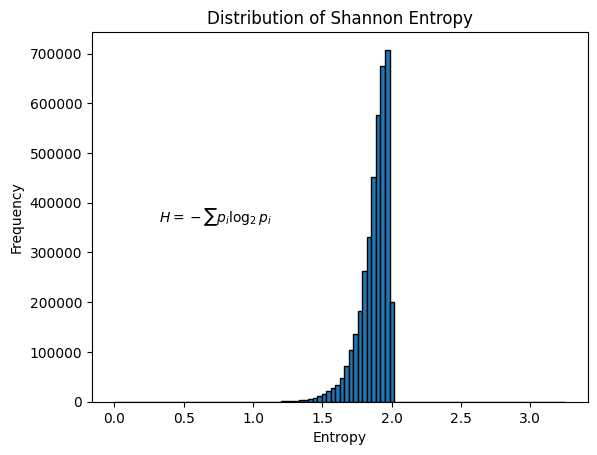

In [171]:
print(spacer_df["entropy"].describe())
# quick plot of the entropy distribution
import matplotlib.pyplot as plt
plt.hist(spacer_df["entropy"], bins=100, edgecolor='black')
plt.title('Distribution of Shannon Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.text(0.25, 0.5, '$H = -\sum p_{i}\log_{2} p_{i}$', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

Adding a column for the number of masked bases in a spacer when using pydustmasker with a window size of 5 and a score threshold of 6.

In [180]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=20, score_threshold=16).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked")
    )
spacer_df["low_compx_n_masked"].value_counts().sort(by="low_compx_n_masked", descending=True)

low_compx_n_masked,count
i64,u32
40,3
39,3
38,6
37,6
36,10
…,…
9,1847
8,8713
7,35546


In [130]:
low_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") > 0)
low_compx_spacers


seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,i64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,24
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,23
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,25
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,20
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,23
…,…,…,…,…,…,…,…,…
"""GCF_963853645.1:NZ_OY970457.1:…","""GACCCCGCCCCGACCCACCAGCGCAG""",26,0.0,0.192308,0.0,0.576923,0.230769,8
"""GCF_963924895.1:NZ_CAWURG01000…","""GACCGGCGCAGGGACGCAAGCGGCGAGGGG…",32,0.0,0.21875,0.0,0.25,0.53125,4
"""GCF_964023245.1:NZ_OZ026884.1:…","""CGCCCCAGCCGCCGCCCCCGGAGCCCGGCC…",35,0.0,0.114286,0.0,0.6,0.285714,9


In [172]:
high_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") == 0)
high_compx_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked,characters,entropy
str,str,u32,f64,f64,f64,f64,f64,i64,list[str],f64
"""GCA_902500825.1:CABVRX01000002…","""TTCTTTGTTTCTTCTTTGTTCCTTCTTTGT…",32,0.0,0.0,0.71875,0.1875,0.09375,0,"[""T"", ""T"", … ""T""]",1.115419
"""MGYG000080391:MGYG000080391_30…","""TTTCATTTATTCTTTCTATTTGTCTATTT""",29,0.0,0.137931,0.689655,0.137931,0.034483,0,"[""T"", ""T"", … ""T""]",1.325617
"""GCA_018399255.1:JAGYPA01000020…","""TTGTATTTGTTTATCTTTATTTACTTGTTT…",35,0.0,0.114286,0.685714,0.114286,0.085714,0,"[""T"", ""T"", … ""T""]",1.392312
"""GCA_018260445.1:JAGLBE01000023…","""GAATTATTTATTTATTTATTTATTTATT""",28,0.0,0.285714,0.678571,0.0,0.035714,0,"[""G"", ""A"", … ""T""]",1.06769
"""MGYG000017260:MGYG000017260_21…","""TTTCTATTGTTGGTTTATTGTTGTTGTTTG…",34,0.0,0.058824,0.676471,0.029412,0.235294,0,"[""T"", ""T"", … ""T""]",1.2627
…,…,…,…,…,…,…,…,…,…,…
"""GCF_964210535.1:NZ_CAXOMR01000…","""CGCGGAACCACAGGCCAGCCACAGGGCC""",28,0.0,0.25,0.0,0.428571,0.321429,0,"[""C"", ""G"", … ""C""]",1.550199
"""GCF_964211445.1:NZ_CAXOQT01000…","""CCAACCCGCAGCCCACGCACCGGCAGCAGA…",32,0.0,0.25,0.0,0.5,0.25,0,"[""C"", ""C"", … ""C""]",1.5
"""GCF_964211445.1:NZ_CAXOQT01000…","""GCCAACCCGCAGCCCACGCACCGGCAGCAG…",33,0.0,0.242424,0.0,0.484848,0.272727,0,"[""G"", ""C"", … ""C""]",1.513202


In [177]:
low_entropy_spacers = spacer_df.filter(pl.col("entropy") <= 1.4)
low_entropy_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked,characters,entropy
str,str,u32,f64,f64,f64,f64,f64,i64,list[str],f64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,24,"[""T"", ""T"", … ""T""]",0.420026
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,23,"[""T"", ""T"", … ""T""]",0.76651
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,25,"[""T"", ""G"", … ""T""]",0.76651
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,20,"[""T"", ""T"", … ""T""]",0.578795
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,23,"[""T"", ""T"", … ""T""]",0.613619
…,…,…,…,…,…,…,…,…,…,…
"""GCF_934476685.1:NZ_CAKSNX01000…","""GAGCGGAGCGCAGGGGCGAGGGGGAGCAGA…",34,0.0,0.235294,0.0,0.176471,0.588235,9,"[""G"", ""A"", … ""A""]",1.3831
"""MGYG000304187:MGYG000304187_9:…","""AGAAGAAAAAGAGACACCAGAAGAGCAGGA…",34,0.0,0.558824,0.0,0.147059,0.294118,5,"[""A"", ""G"", … ""G""]",1.395123
"""GCF_964023245.1:NZ_OZ026884.1:…","""CGCCCCAGCCGCCGCCCCCGGAGCCCGGCC…",35,0.0,0.114286,0.0,0.6,0.285714,9,"[""C"", ""G"", … ""A""]",1.316199


In [ ]:
fourmer_spacers = high_compx_spacers.filter(
    pl.all_horizontal(pl.selectors.starts_with("a_", "c_", "g_", "t_") > 0) &
    ~pl.any_horizontal(pl.selectors.starts_with("n_") > 0) 
)
fourmer_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked,characters,entropy
str,str,u32,f64,f64,f64,f64,f64,i64,list[str],f64
"""MGYG000080391:MGYG000080391_30…","""TTTCATTTATTCTTTCTATTTGTCTATTT""",29,0.0,0.137931,0.689655,0.137931,0.034483,0,"[""T"", ""T"", … ""T""]",1.325617
"""GCA_018399255.1:JAGYPA01000020…","""TTGTATTTGTTTATCTTTATTTACTTGTTT…",35,0.0,0.114286,0.685714,0.114286,0.085714,0,"[""T"", ""T"", … ""T""]",1.392312
"""MGYG000017260:MGYG000017260_21…","""TTTCTATTGTTGGTTTATTGTTGTTGTTTG…",34,0.0,0.058824,0.676471,0.029412,0.235294,0,"[""T"", ""T"", … ""T""]",1.2627
"""MGYG000192913:MGYG000192913_11…","""ATATTCTTTATTATTTCTATTTATTGTCTT""",30,0.0,0.2,0.666667,0.1,0.033333,0,"[""A"", ""T"", … ""T""]",1.350116
"""MGYG000305898:MGYG000305898_10…","""CTGCTTTCTTTATTTGTTAATTTCTTTGTT""",30,0.0,0.1,0.666667,0.133333,0.1,0,"[""C"", ""T"", … ""T""]",1.441946
…,…,…,…,…,…,…,…,…,…,…
"""3300011491_2:Ga0122279_100153:…","""CGCAACCAAGACGACGGCGGCGAAGAAGGC…",40,0.0,0.325,0.025,0.3,0.35,0,"[""C"", ""G"", … ""G""]",1.711222
"""GCF_900605005.1:NZ_LR027558.1:…","""GTGAGCCCAACACCAGCAGCGCCGCCACCA…",40,0.0,0.3,0.025,0.45,0.225,0,"[""G"", ""T"", … ""A""]",1.65674
"""GCF_963529995.1:NZ_CAUSCY01000…","""TCGACCGCAGCGAAGAAGACCACCGCGACC…",40,0.0,0.3,0.025,0.4,0.275,0,"[""T"", ""C"", … ""G""]",1.695096


In [ ]:
N_spacers = spacer_df.filter(pl.col("n_frac") > 0)
N_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,i64
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTTATCACCTTTTAAAGATTTTTAAG…",38,0.026316,0.236842,0.605263,0.078947,0.052632,18
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTATCACCTTTTAAAGATTTTTAAGN…",37,0.027027,0.243243,0.594595,0.081081,0.054054,17
"""GCA_003483675.1:DMYK01000440.1…","""TGCTTCTTCTATTTGTTGTTTACGTTGTGN…",31,0.064516,0.064516,0.548387,0.129032,0.193548,0
"""GCA_020692945.1:JAIMJY01000008…","""TATATTTTATATTTTATTTTTATNNNNNNN…",34,0.323529,0.176471,0.5,0.0,0.0,5
"""GCA_016841625.1:JAENYU01000001…","""TTACTTTTTTNNNNNNNNNNTTTCCTTTAC…",31,0.322581,0.064516,0.483871,0.129032,0.0,6
…,…,…,…,…,…,…,…,…
"""MGYG000051310:MGYG000051310_92…","""NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,1.0,0.0,0.0,0.0,0.0,0
"""GCF_900129055.1:NZ_FQUZ0100002…","""GAGGAANNNNNNNNNNNNNNNNNNNNNNNN…",32,0.78125,0.09375,0.0,0.0,0.125,0
"""GCF_900230225.1:NZ_OCNH0100000…","""CNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,0.944444,0.0,0.0,0.055556,0.0,0


(Next steps are in the subsampling notebook)